# 1. Setup and Load Data

Dependencies

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

Working Directories

In [109]:
# work directories
WORKDIR = os.path.abspath('') # get the path of this file - image metadata
IMAGESDIR = os.path.join(WORKDIR, 'images') # get the path of image folder

In [110]:
# read metadata
metadata_df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
# print(metadata_df) -> view data

## 1.1 Prepare the data for use
In this task, we are interested to see if the model can predict values 'WindowCenter' and 'WindowWidth' from the image alone,
without other metadata. Therefore, other columns will be dropped. The effect of other metadata will be explored later.

In [111]:
# drop columns that aren't needed
metadata_df = metadata_df.drop(columns=['Modality', 'Rows', 'Columns', 'BodyPartExamined', 'HighBit', 'StudyDescription'])
# print(metadata_df) -> view data after dropping columns

Upon inspecting the data, it can be seen that some of it is in a different format, namely [number, number] while majority of it is a single number. For the time being, these rows will be removed from the dataset.
By running the 'type(metadata_df.iloc[0,0])' command, it can be checked which data type are the values, in this case it is string. Therefore, values that do not match the standard format can be removed with string condition.

Since some rows contain two values for window center and width, only the first value will be used for analysis. This is how the original paper this is based on did it so that's how I'm doing it too.

In [112]:
# This function finds cells that contain two instead of one number and returns only the first number
def extract_number_from_list(val):
    if ',' in val:
        idx = val.find(',')
        return val[1:idx]
    else:
        return val

    
metadata_df = metadata_df.applymap(extract_number_from_list)

In [113]:
# since ML models require numeric data, string values will be converted to float
metadata_df['WindowCenter'] = metadata_df['WindowCenter'].astype('float32')
metadata_df['WindowWidth'] = metadata_df['WindowWidth'].astype('float32')

# print(metadata_df) -> check data after conversion

## WARNING
Due to testing the model on my local machine, which has very limited resources and doesn't support GPU computation, I decided
to limit the amount of data that will be used during testing phase. Delete this when working on the final stages.

In [114]:
# Keep only N rows
metadata_df = metadata_df.head(1000)

## 1. 2 Loading the images

In [115]:
# this function will read an image with file_name from images directory
# images are already in numpy format
def read_file(file_name):
    imagepath = os.path.join(IMAGESDIR, f'{file_name}.npy')
    with open(imagepath, 'rb') as file:
        img = np.load(file)
    return img

In [116]:
# load image arrays into a large list of images
images_list = []
  
for i in range(len(metadata_df)):
    img = read_file(metadata_df.index[i])
    
    images_list.append(img)

#since images are loaded into a list, they will be converted into a numpy array
images = np.array(images_list, dtype=np.ndarray)

In [117]:
# add padding to the images so they're all the same size
for i in range(len(images)):
    images[i] = keras.utils.pad_sequences(images[i], value=0,padding='post', maxlen=512)
    
images = keras.utils.pad_sequences(images, value=0,padding='post', maxlen=512)

# negative values will be shown as black, so they are converted to 0
images[images < 0] = 0

# Grayscale images have 1 color channel. This dimension is dropped by default so it has to be
# added back manually
images = np.expand_dims(images, -1)

# Normalize the data
images = images / 65535

In [118]:
images.shape

(1000, 512, 512, 1)

In [119]:
y_center = np.expand_dims(metadata_df['WindowCenter'].to_numpy(), -1)
y_width = np.expand_dims(metadata_df['WindowWidth'].to_numpy(), -1)

In [120]:
# images_ds = tf.data.Dataset.from_tensor_slices((images, (y_center, y_width)))
images_ds = tf.data.Dataset.from_tensor_slices((images, (metadata_df['WindowCenter'].to_numpy(), metadata_df['WindowWidth'].to_numpy())))

In [121]:
train_size = int(len(images_ds) * .8)
val_size = int(len(images_ds) * .1)
test_size = int(len(images_ds) * .1)

train = images_ds.take(train_size)
val = images_ds.skip(train_size).take(val_size)
test = images_ds.skip(train_size+val_size).take(test_size)

In [122]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [123]:
lst = list(train.as_numpy_iterator())
print(lst[0][0].shape)

(32, 512, 512, 1)



\# choose train, validation and test rations
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

\# train is now 80% of the entire data set
\# pandas dataframe will be converted to numpy array
#x_train, x_test, y_train, y_test = train_test_split(images, metadata_df.to_numpy(), test_size=1 - train_ratio)
x_train, x_test, y_train_c, y_test_c = train_test_split(images, y_center, test_size=1 - train_ratio)
y_train_w = y_width[0:len(y_train_c)]
y_test_w = y_width[len(y_train_c):]

\# test is now 10% of the initial data set
\# validation is now 10% of the initial data set
#x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
x_val, x_test, y_val_c, y_test_c = train_test_split(x_test, y_test_w, test_size=test_ratio/(test_ratio + validation_ratio)) 
y_val_w = y_test_w[len(y_val_c):]


In [124]:
#y={"window_center": y_train_c,
#  "window_width" : y_train_w}

In [125]:
# plt.imshow(data_list[4][0], cmap="bone")

# TESTING

# MODEL BUILDING

In [126]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout

def build_model():
    inputs = Input(shape=(512, 512, 1))
    x = Conv2D(8, (3,3), 1, activation='relu') (inputs)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, (3,3), 1, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, (3,3), 1, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, (3,3), 1, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, (3,3), 1, activation='relu') (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)
    x = Dense(256, activation='relu') (x) 
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=inputs, outputs=[output1, output2])
    
    return model

model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

optim = keras.optimizers.Adam()

model.compile(optimizer=optim, loss=losses, metrics=metrics)

In [127]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 510, 510, 8)  80          ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 255, 255, 8)  0          ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 253, 253, 16  1168        ['max_pooling2d_5[0][0]']  

In [128]:
# model.fit(scaled_test, epochs=1, validation_data=val_data)
history = model.fit(train, epochs=10, validation_data=val, batch_size=32, verbose=1)
#history = model.fit(x_train, y=y, batch_size=32, epochs=1, verbose=1)

Epoch 1/10
25/25 [==============================] - 50s 2s/step - loss: 4632514.0000 - window_center_loss: 1460726.7500 - window_width_loss: 3171787.7500 - window_center_root_mean_squared_error: 1208.6053 - window_width_root_mean_squared_error: 1780.9514 - val_loss: 1927163.6250 - val_window_center_loss: 853735.0625 - val_window_width_loss: 1073428.7500 - val_window_center_root_mean_squared_error: 923.9778 - val_window_width_root_mean_squared_error: 1036.0641
Epoch 2/10
25/25 [==============================] - 45s 2s/step - loss: 1910542.5000 - window_center_loss: 717294.5000 - window_width_loss: 1193247.6250 - window_center_root_mean_squared_error: 846.9324 - window_width_root_mean_squared_error: 1092.3588 - val_loss: 1423134.3750 - val_window_center_loss: 705969.2500 - val_window_width_loss: 717165.2500 - val_window_center_root_mean_squared_error: 840.2198 - val_window_width_root_mean_squared_error: 846.8561
Epoch 3/10
25/25 [==============================] - 45s 2s/step - loss: 1316

In [144]:
model.evaluate(test)

4/4 [==============================] - 1s 293ms/step - loss: 670636.6250 - window_center_loss: 212081.7188 - window_width_loss: 458554.9062 - window_center_root_mean_squared_error: 460.5233 - window_width_root_mean_squared_error: 677.1668


[670636.625, 212081.71875, 458554.90625, 460.5233154296875, 677.1668090820312]

In [141]:
a_random_x = read_file('4520043')
a_random_x = a_random_x / 65535
a_random_x = np.expand_dims(a_random_x, -1)
a_random_x = keras.utils.pad_sequences(a_random_x, value=0,padding='post', maxlen=512)
a_random_x = keras.utils.pad_sequences(a_random_x[0], value=0,padding='post', maxlen=512)
a_random_x = np.expand_dims(a_random_x, -1)
a_random_x = np.expand_dims(a_random_x, 0)

y_pred = model.predict(a_random_x)
y_pred

(1, 512, 512, 1)

In [135]:
test_list = list(test.as_numpy_iterator())

In [136]:
test_list[0][1][0]

array([1500.,  324., 2286.,  498.,  708., 1631., 2075., 1995., -600.,
       -600., 2107., 2235., 2048., 1161., 1500., 1115., 1824., 2048.,
         40., 1862.,  400., 2105., 1751.,   40., 1500., 1500., 1500.,
       1906., -600., 1918., 2451., 1951.], dtype=float32)

In [137]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()
    
# Run predict
Y_pred = model.predict(test)
center_pred = Y_pred[0]
width_pred = Y_pred[1]

4/4 [==============================] - 2s 428ms/step


In [149]:
len(center_pred[32:64])

32

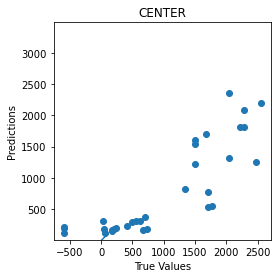

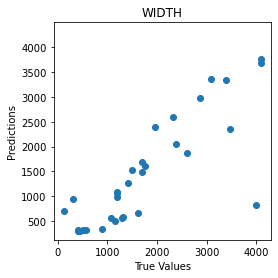

In [150]:
plot_diff(test_list[1][1][0], center_pred[32:64], title='CENTER')
plot_diff(test_list[1][1][1], width_pred[32:64], title='WIDTH')